In [1]:
pip install causalgraphicalmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

from sklearn.linear_model import LinearRegression
import math
import itertools

# Continuous model

Generating the model

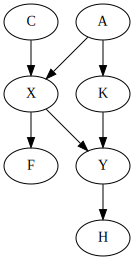

In [3]:
fd_cont = StructuralCausalModel({
    "C": lambda n_samples: np.random.uniform(low=-10, high=10,
                                             size=n_samples),
    "A": lambda n_samples: .8 * np.random.normal(size=n_samples),
    "K": lambda A, n_samples: A + .1 * np.random.normal(),
    "X": lambda C, A, n_samples: 0.7 * C - 2 * A + .2 * np.random.normal(),
    "F": lambda X, n_samples: 3 * X + .8 * np.random.normal(),
    "Y": lambda K, X, n_samples: 2 * K - X + .2 * np.random.normal(),
    "H": lambda Y, n_samples: .5 * Y + .1 * np.random.normal()
})

fd_cont.cgm.draw()

In [4]:
data_df = fd_cont.sample(n_samples=1000000)

In [5]:
data_df

,C,A,K,X,F,Y,H
0,6.650511,-0.320592,-0.408399,5.120008,15.170171,-5.816752,-2.967361
1,-4.154769,0.512551,0.424743,-4.109973,-12.519771,5.079513,2.480772
2,-6.840869,-0.371536,-0.459343,-4.222071,-12.856063,3.423438,1.652734
3,7.788480,0.764107,0.676300,3.747188,11.051713,-2.274536,-1.196253
4,3.373573,-1.249247,-1.337055,4.683462,13.860535,-7.237518,-3.677744
...,...,...,...,...,...,...,...
999995,-0.619026,0.363656,0.275849,-1.337165,-4.201346,2.008916,0.945473
999996,-9.176910,0.326830,0.239023,-7.254030,-21.951943,7.852129,3.867080
999997,4.258980,0.245275,0.157468,2.314201,6.752753,-1.879212,-0.998591
999998,-4.161409,-0.139992,-0.227799,-2.809536,-8.618458,2.473990,1.178010


Excercise 1:

Implement backdoor adjustment for arbitrary treatment, effect and conditioning set using Linear Regression.

Check if your implementation is working correctly.

In [6]:
all_sets = [
            ['C'],
            ['A'],
            ['K'],
            ['F'],
            ['H'],
            ['C', 'A'],
            ['C', 'K'],
            ['C', 'F'],
            ['C', 'H'],
            ['A', 'K'],
            ['A', 'F'],
            ['A', 'H'],
            ['K', 'F'],
            ['K', 'H'],
            ['F', 'H'],
            ['C', 'A', 'K'],
            ['C', 'A', 'F'],
            ['C', 'A', 'H'],
            ['C', 'K', 'F'],
            ['C', 'K', 'H'],
            ['C', 'F', 'H'],
            ['A', 'K', 'F'],
            ['A', 'K', 'H'],
            ['K', 'F', 'H'],
            ['C', 'A', 'K', 'F'],
            ['C', 'A', 'K', 'H'],
            ['C', 'K', 'F', 'H'],
            ['A', 'K', 'F', 'H'],
            ['C', 'A', 'K', 'F', 'H']
            ]

In [7]:
def my_backdoor_adjustment_regression(data=data_df, T='X', Y='Y', cond_set = ['A', 'K'], true_ate=None):
    # add your implementation
    # conditioning set can be empty, can contain 1 or more variables.
    # conditioning set never contains T or Y
    regressor = LinearRegression()
    # Regressing Y on [T, cond_set]
    regressor.fit(data[list(T) + cond_set].values, data[Y].values)  
    # Reporting coefficient of T
    print(f"Set: {list(T) + cond_set}, X has the coefficient: {regressor.coef_[0]}")
    coeff_X = regressor.coef_[0]
    # Check if the estimation is close to the actual causal effect
    if math.isclose(coeff_X, true_ate, rel_tol=1e-2) == True:
      return True
    else:
      return False   
        

In [8]:
my_backdoor_adjustment_regression(data_df, T='X', Y='Y', cond_set=[], true_ate = -1)

Set: ['X'], X has the coefficient: -1.135334971948601


False

In [9]:
adj_sets = []
for var_set in all_sets:
  if my_backdoor_adjustment_regression(data_df, T='X', Y='Y', cond_set=var_set, true_ate = -1) == True:
    adj_sets.append(var_set)

Set: ['X', 'C'], X has the coefficient: -2.0
Set: ['X', 'A'], X has the coefficient: -0.9999999999999992
Set: ['X', 'K'], X has the coefficient: -0.9999999999999992
Set: ['X', 'F'], X has the coefficient: -0.11353349719486007
Set: ['X', 'H'], X has the coefficient: -4.354319421746463e-16
Set: ['X', 'C', 'A'], X has the coefficient: -1.2873858477782487
Set: ['X', 'C', 'K'], X has the coefficient: -1.287229549182047
Set: ['X', 'C', 'F'], X has the coefficient: -0.2000000000000001
Set: ['X', 'C', 'H'], X has the coefficient: -0.023316120548377693
Set: ['X', 'A', 'K'], X has the coefficient: -0.9999999999999994
Set: ['X', 'A', 'F'], X has the coefficient: -0.09999999999999998
Set: ['X', 'A', 'H'], X has the coefficient: -0.44444444444444436
Set: ['X', 'K', 'F'], X has the coefficient: -0.09999999999999998
Set: ['X', 'K', 'H'], X has the coefficient: -0.44444444444444436
Set: ['X', 'F', 'H'], X has the coefficient: 7.785994183720635e-17
Set: ['X', 'C', 'A', 'K'], X has the coefficient: -1.3

In [10]:
adj_sets

[['A'], ['K'], ['A', 'K']]

Valid adjustments sets:

In [11]:
fd_cont.cgm.get_all_backdoor_adjustment_sets(x='X', y='Y')

frozenset({frozenset({'A'}),
           frozenset({'K'}),
           frozenset({'A', 'C'}),
           frozenset({'C', 'K'}),
           frozenset({'A', 'K'}),
           frozenset({'A', 'C', 'K'})})

We notice that from the sets that adjustment sets (obtained by `get_all_backdoor_adjustment_sets`), those containing the random variable $C$ is missing fomr the sets contained in `adj_sets`.

This is due to the choice of linear regression as method of estimation. Choosing the right model would overcome this issue.



# Discrete model


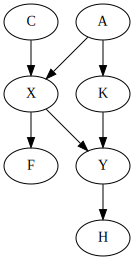

In [12]:
fd_disc = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.7, size=n_samples),
    "A": lambda n_samples: np.random.binomial(n=1, p=0.2, size=n_samples),
    "K": lambda A, n_samples: A + .1 * np.random.normal(),
    "K": discrete_model(["A"], {
        (0, ): (0.9, 0.1),
        (1, ): (0.3, 0.7),
        }),
    "X": discrete_model(["C", "A"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.7, 0.3),
        (1, 0): (0.5, 0.5),
        (1, 1): (0.8, 0.2),
        }),  
    "F": discrete_model(["X"], {
        (0, ): (0.6, 0.4),
        (1, ): (0.1, 0.9),
        }),
    "Y": discrete_model(["K", "X"], {
        (0, 0): (0.9, 0.1), 
        (0, 1): (0.3, 0.7),
        (1, 0): (0.2, 0.5),
        (1, 1): (0.5, 0.5),
        }),
    "H": discrete_model(["Y"], {
        (0, ): (0.2, 0.4, 0.4),
        (1, ): (0.8, 0.1, 0.1),
        }),
})

fd_disc.cgm.draw()

In [13]:
data_disc = fd_disc.sample(n_samples = 1000000)
data_disc.head()

,C,A,K,X,F,Y,H
0,1,0,0.0,1.0,1.0,1.0,1.0
1,0,0,0.0,1.0,1.0,1.0,0.0
2,1,0,0.0,1.0,1.0,0.0,2.0
3,1,0,0.0,1.0,1.0,1.0,0.0
4,1,0,0.0,1.0,1.0,1.0,0.0


In [14]:
data_disc.describe()

,C,A,K,X,F,Y,H
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.699821,0.200181,0.220040,0.541990,0.670559,0.493642,0.756601
std,0.458336,0.400136,0.414274,0.498234,0.470010,0.499960,0.830105
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


Identifying True causal effect:

In [15]:
set_variable_X = np.array([0]*500000 + [1]*500000)
ab_test_df = fd_disc.do('X').sample(
                    set_values={'X': set_variable_X}, 
                    n_samples=len(set_variable_X),
                  )
ab_test_df.head()

,C,A,X,K,F,Y,H
0,0,0,0,0.0,1.0,0.0,2.0
1,1,1,0,1.0,0.0,1.0,1.0
2,1,0,0,0.0,1.0,0.0,1.0
3,0,0,0,0.0,0.0,0.0,1.0
4,1,1,0,1.0,0.0,0.0,1.0


In [16]:
true_ate = ab_test_df[ab_test_df['X'] == 1]['Y'].mean() - ab_test_df[ab_test_df['X'] == 0]['Y'].mean()
true_ate

0.421102

Excercise 2:

1. Can we estimate causal effect for discrete model using regression? Try using the function you implemented above.
2. Test all possible adjustment sets. Are there any additional adjustments sets with correct result?

Valid backdoor adjustment sets

In [17]:
fd_disc.cgm.get_all_backdoor_adjustment_sets(x='X', y='Y')

frozenset({frozenset({'A'}),
           frozenset({'K'}),
           frozenset({'A', 'C'}),
           frozenset({'C', 'K'}),
           frozenset({'A', 'K'}),
           frozenset({'A', 'C', 'K'})})

In [18]:
adj_sets = []
for var_set in all_sets:
  if my_backdoor_adjustment_regression(data_disc, T='X', Y='Y', cond_set=var_set, true_ate = true_ate) == True:
    adj_sets.append(var_set)

Set: ['X', 'C'], X has the coefficient: 0.37293766271735795
Set: ['X', 'A'], X has the coefficient: 0.4404593752346957
Set: ['X', 'K'], X has the coefficient: 0.4252138245748803
Set: ['X', 'F'], X has the coefficient: 0.3844346174584024
Set: ['X', 'H'], X has the coefficient: 0.28331230244509087
Set: ['X', 'C', 'A'], X has the coefficient: 0.43473660362791644
Set: ['X', 'C', 'K'], X has the coefficient: 0.4183117337127982
Set: ['X', 'C', 'F'], X has the coefficient: 0.37312204350269373
Set: ['X', 'C', 'H'], X has the coefficient: 0.2753776122804047
Set: ['X', 'A', 'K'], X has the coefficient: 0.4404817912151069
Set: ['X', 'A', 'F'], X has the coefficient: 0.44065115457669013
Set: ['X', 'A', 'H'], X has the coefficient: 0.3278472458403265
Set: ['X', 'K', 'F'], X has the coefficient: 0.4253146468337526
Set: ['X', 'K', 'H'], X has the coefficient: 0.31836572602559005
Set: ['X', 'F', 'H'], X has the coefficient: 0.2836500139738582
Set: ['X', 'C', 'A', 'K'], X has the coefficient: 0.4348857

In [19]:
adj_sets

[['K'], ['C', 'K'], ['K', 'F'], ['C', 'K', 'F']]

Based on what we observe next, applying regression on descrete dataset captures a small subset of the adjust sets.

Excercise 3:

1. Implement backdoor adjustment for arbitrary treatment, effect and conditioning set using ATE formula.

Hint: you can use dummy variable to split your dataset according to all possible combinations of confounders.

Check if your implementation is working correctly.

2. Test all possible adjustment sets. Are there any additional adjustments sets with correct result?

In [28]:
def my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set = ['A', 'K'], true_ate=None):
    # add your implementation
    # conditioning set can be empty, can contain 1 or more variables.
    # conditioning set never contains T or Y
    if len(cond_set) == 0:
      ATE = data[data[T] == 1][Y].mean() - data[data[T] == 0][Y].mean()
    else:
      variable_values = []
      n = len(cond_set)
      ## list of lists that inner list (i) contain all values of ith variable in cond_set
      variable_values = [data[cond_set[i]].unique().astype(int).tolist() for i in range(n)]
      ## convert every value to character
      variable_values_char = [list(map(str, variable)) for variable in variable_values]
      ## construct all possible combination of values for variables of cond_set
      combinations = list(itertools.product(*variable_values_char ))
      ## now using the combinations we construct all possible queries within the data (dataframe)
      queries = []
      for i in range(len(combinations)):
        query_string = ''
        for j in range(n):
          query_string += f'{cond_set[j]} == {combinations[i][j]} and '
          if j == n-1:
            # remove the last " and " from the string 
            queries.append(query_string[:-5])
      ## example of an element in the queries list: 'A == 0 and K == 0'      
      ATE = 0
      ## Obtain possible values of X
      X_values = data[T].unique().astype(int).tolist()
      X_values.sort()
      ATE_terms = []
      counter = 0
      for x in X_values:
        ATE_terms.append(0)
        for q in queries:
          ## Add current value of x to the query q (q is obtained from list of all possible queries, over which we are iterating)
          ## example of q: "A == 1 and K == 0"
          ## example of nq: "X == 0 and A == 1 and K == 0"
          nq = f'{T} == {x} and ' + q
          #print(nq)
          ## Probability of the event q occurring
          size = data.query(q).shape[0] / data.shape[0]
          ## Calucate expectation of Y based on the new query (nq) that adds current values of x to the query
          E_Y = data.query(nq)[Y].mean()
          ## Calculate E_Y conditioned on nq (query q + value of x)
          ## the condition has all values of the confounders and also the value of x
          ATE_terms[counter] += size * E_Y
        counter += 1;
      ## Since X (treatment) has 2 values, the following quantity would be just ATE[0] - ATE[1]
      #ATE = ATE_terms[-1] - sum(ATE_terms[:-1])  
      ATE = ATE_terms[1] - ATE_terms[0]
    print(f"ATE for set {cond_set}: {ATE}")
    if math.isclose(ATE, true_ate, rel_tol=1e-2) == True:
      return True
    else:
      return False    

An example of the function above with printing of `nq`, which is all queries possible:



```
my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set = ['A', 'K','C'], true_ate=true_ate)

X == 0 and A == 0 and K == 0 and C == 1
X == 0 and A == 0 and K == 0 and C == 0
X == 0 and A == 0 and K == 1 and C == 1
X == 0 and A == 0 and K == 1 and C == 0
X == 0 and A == 1 and K == 0 and C == 1
X == 0 and A == 1 and K == 0 and C == 0
X == 0 and A == 1 and K == 1 and C == 1
X == 0 and A == 1 and K == 1 and C == 0
X == 1 and A == 0 and K == 0 and C == 1
X == 1 and A == 0 and K == 0 and C == 0
X == 1 and A == 0 and K == 1 and C == 1
X == 1 and A == 0 and K == 1 and C == 0
X == 1 and A == 1 and K == 0 and C == 1
X == 1 and A == 1 and K == 0 and C == 0
X == 1 and A == 1 and K == 1 and C == 1
X == 1 and A == 1 and K == 1 and C == 0
ATE for set ['A', 'K', 'C']: 0.4205944422454969
True
```




Examples but without printing queries

In [29]:
my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set = ['A', 'K','C'], true_ate=true_ate)

ATE for set ['A', 'K', 'C']: 0.4205944422454969


True

In [30]:
my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set = ['A', 'K','C'], true_ate=true_ate)

ATE for set ['A', 'K', 'C']: 0.4205944422454969


True

In [31]:
my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set = ['A', 'K','C'], true_ate=true_ate)

ATE for set ['A', 'K', 'C']: 0.4205944422454969


True

In [32]:
my_backdoor_adjustment_descrete(data=data_disc, T='X', Y='Y', cond_set=[], true_ate=true_ate)

ATE for set []: 0.38421361010888383


False

In [33]:
true_ate

0.421102

In [34]:
adj_sets = []
for var_set in all_sets:
  if my_backdoor_adjustment_descrete(data_disc, T='X', Y='Y', cond_set=var_set, true_ate = true_ate) == True:
    adj_sets.append(var_set)

ATE for set ['C']: 0.36371349895589755
ATE for set ['A']: 0.42037748504142797
ATE for set ['K']: 0.42046632018809266
ATE for set ['F']: 0.3843481901553542
ATE for set ['H']: 0.2595144158286714
ATE for set ['C', 'A']: 0.4207140808715909
ATE for set ['C', 'K']: 0.4207977773478024
ATE for set ['C', 'F']: 0.36388248329465633
ATE for set ['C', 'H']: 0.24450287429919432
ATE for set ['A', 'K']: 0.4203746110568032
ATE for set ['A', 'F']: 0.4206926700567192
ATE for set ['A', 'H']: 0.3055643570270179
ATE for set ['K', 'F']: 0.4209085213244582
ATE for set ['K', 'H']: 0.3276627686357656
ATE for set ['F', 'H']: 0.260235241194004
ATE for set ['C', 'A', 'K']: 0.420594442245497
ATE for set ['C', 'A', 'F']: 0.42145919644711627
ATE for set ['C', 'A', 'H']: 0.3067695225152884
ATE for set ['C', 'K', 'F']: 0.42116111995193506
ATE for set ['C', 'K', 'H']: 0.3284037811594251
ATE for set ['C', 'F', 'H']: 0.24538088565356692
ATE for set ['A', 'K', 'F']: 0.4207681230860008
ATE for set ['A', 'K', 'H']: 0.3278082

In [35]:
adj_sets

[['A'],
 ['K'],
 ['C', 'A'],
 ['C', 'K'],
 ['A', 'K'],
 ['A', 'F'],
 ['K', 'F'],
 ['C', 'A', 'K'],
 ['C', 'A', 'F'],
 ['C', 'K', 'F'],
 ['A', 'K', 'F'],
 ['C', 'A', 'K', 'F']]

The difference between the function I wrote and the built-in function `fd_disc.cgm.get_all_backdoor_adjustment_sets`, is that my function adds variable F to the combinations of adjust sets as well.

